# Physical systems
> Physcial system examples.

In [ ]:
#| default_exp examples.physics

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from simbox.basics import *
from pydrake.examples import AcrobotPlant
from scipy.interpolate import CubicSpline

## Double pendulum

![[The Acrobot|MIT Course](https://underactuated.mit.edu/acrobot.html#section1)](./fig/acrobot.png){width=200}

Refer to the drawing of the Acrobot, a double pendulum is even simpler with mass concentrated at the end of each rod, i.e. $l_{c1/2}=l_{1/2}, I_{1/2}=0$. Note that the joint angle $q_2$ is _relative_.

In [ ]:
#| export
class DoublePendulumSimBox(SimpleCSimBox):
    "To quickly make a double pendulum simulation."
    def __init__(self, m1=1., m2=1., l1=1., l2=1., b1=0., b2=0., g=9.81, log_period=0.0):
        sys = AcrobotPlant()
        sys.set_name('double_pendulum')
        # m1, m2, l1, l2, lc1, lc2, Ic1, Ic2, b1, b2, gravity
        self.params = [m1,m2,l1,l2,l1,l2,0.,0.,b1,b2,g]
        super().__init__(sys, log_period=log_period)

    def initialize(self, inp_val, state_val=None, force_init=False):
        "Set constant torque control `inp_val`; initial state `state_val`."
        if self._is_init and not force_init: return
        self.ctx = self.dgm.CreateDefaultContext()
        self.get_inp().FixValue(self.ctx, inp_val)
        _ctx = self.sys.GetMyContextFromRoot(self.ctx)
        self.sys.get_mutable_parameters(_ctx).set_value(self.params)
        if state_val is not None: self.ctx.SetContinuousState(state_val)
        self.sim = Simulator(self.dgm, self.ctx)
        self._is_init = True
    
    def get_log_energy(self):
        ts,pos,vels = self.get_log_items_cartesian()
        (m1,m2,l1,l2),g = self.params[:4],self.params[-1]
        KEs = (.5 * m1 * (vels[0]**2).sum(axis=1) + .5 * m2 * (vels[1]**2).sum(axis=1))
        PEs = m1 * g * pos[0][:,1] + m2 * g * pos[1][:,1]
        return ts, KEs + PEs
    
    def get_log_items_cartesian(self):
        l1,l2 = self.params[2:4]
        ts, (t1,t2,w1,w2) = self.get_state_log_items()
        pos1 = np.column_stack([l1 * np.sin(t1), -l1 * np.cos(t1)])
        pos2 = np.column_stack([pos1[:,0] + l2 * np.sin(t1 + t2), pos1[:,1] - l2 * np.cos(t1 + t2)])
        vel1 = np.column_stack([l1 * np.cos(t1) * w1, l1 * np.sin(t1) * w1])
        vel2 = np.column_stack([vel1[:,0] + l2 * np.cos(t1 + t2) * (w1 + w2), vel1[:,1] + l2 * np.sin(t1 + t2) * (w1 + w2)])
        return ts, (pos1, pos2), (vel1, vel2)

    def plot_log(self, ax=None, figsize=(3,2)):
        if ax is None: fig,ax = plt.subplots(figsize=figsize)
        ts, vals = self.get_state_log_items()
        ax.plot(ts, vals[0], '-', c='C1', label=r'$\theta_1$')
        ax.plot(ts, vals[1], '-', c='C9', label=r'$\theta_2$')
        ax.plot(ts, vals[2], '--', c='C1', label=r'$\dot\theta_1$')
        ax.plot(ts, vals[3], '--', c='C9', label=r'$\dot\theta_2$')
        ax.set_xlabel('t (sec)')
        ax.legend(loc=1, fontsize=9, ncols=2)
    
    def plot_log_with_energy(self, axs=None, figsize=(7,2)):
        if axs is None: fig,axs = plt.subplots(1,2,figsize=figsize)
        self.plot_log(axs[0])
        ts, es = self.get_log_energy()
        axs[1].plot(ts, es, 'C0-')
        axs[1].plot([ts[0],ts[-1]], [es[0],es[0]], 'k--')
        axs[1].set_xlabel('t (sec)'); axs[1].set_ylabel('Energy')
        try: fig.tight_layout()
        except: pass

    def show_animation(self, figsize=(3,3), smooth_trail=True, save_fname=None):
        "Refer to [animation in nbs](https://jckantor.github.io/CBE30338/A.03-Animation-in-Jupyter-Notebooks.html)"
        fig,ax = plt.subplots(figsize=figsize)
        l1,l2 = self.params[2:4]; l = l1 + l2 + 0.3
        ax.set_xlim((-l, l)); ax.set_ylim((-l, l))
        ax.set_xlabel('x'); ax.set_ylabel('y')
        
        title = ax.set_title('')
        rods, = ax.plot([], [], 'k', lw=3, solid_capstyle='round')
        c1, = ax.plot([], [], 'C7o', mec='k', ms=10) # mass 1
        c2, = ax.plot([], [], 'C7o', mec='k', ms=10) # mass 2
        trail, = ax.plot([], [], 'C1-', lw=2, alpha=.6, solid_capstyle='round')
    
        ts, (pos1,pos2), _ = self.get_log_items_cartesian()
        trail_sz = 5
        def _update(n):
            title.set_text(f'Time = {ts[n]:.1f}')
            rods.set_data([0,pos1[n][0],pos2[n][0]], [0,pos1[n][1],pos2[n][1]])
            c1.set_data([pos1[n][0]], [pos1[n][1]])
            c2.set_data([pos2[n][0]], [pos2[n][1]])
            # Draw a trail, fading into the past
            lb = max(0,n-trail_sz)
            ps = pos2[lb:n+1,:]
            if smooth_trail and len(ps) > 2:
                spl = CubicSpline(np.linspace(0,1,len(ps)), ps)
                ps  = spl(np.linspace(0,1,len(ps)*10))
            trail.set_data(ps[:,0], ps[:,1])
            return (rods,c1,c2,trail)
        
        anim = animation.FuncAnimation(fig, _update, frames=len(ts), interval=200, blit=True, repeat=False)
        fig.tight_layout()
        if save_fname is not None: anim.save(save_fname, writer='pillow')
        plt.close(fig)
        display(HTML(anim.to_html5_video()))

In [ ]:
pend = DoublePendulumSimBox(log_period=0.1)

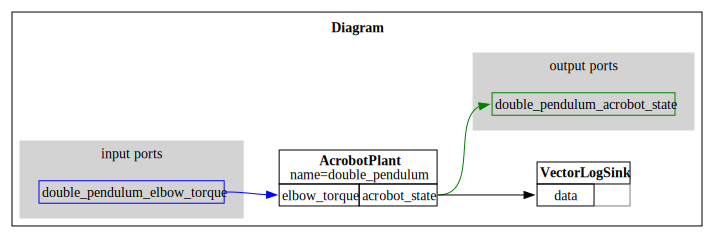

In [ ]:
#| eval: false
viz_diagram(pend.dgm)

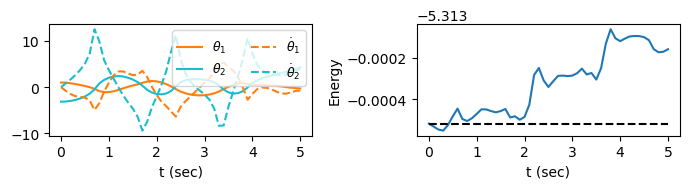

In [ ]:
pend.initialize([0.], [1,-3.14,0,0], force_init=True)
pend.sim.AdvanceTo(5)
pend.plot_log_with_energy()

In [ ]:
#| eval: false
pend.show_animation()

The analytical expression of the EoM of a double pendulum is taken from the tutorial of [Lagrngian NN](https://colab.research.google.com/drive/1CSy-xfrnTX28p1difoTA8ulYw0zytJkq), where `state = (theta1, theta2, theta_dot1, theta_dot2)`.

In [ ]:
#| export
def eom_double_pendulum(state, t=0, m1=1, m2=1, l1=1, l2=1, g=9.81, is_relative=True):
    "Refer to [LNN tutorial](https://colab.research.google.com/drive/1CSy-xfrnTX28p1difoTA8ulYw0zytJkq)"
    t1, t2, w1, w2 = state
    if is_relative : t2 = t2 + t1; w2 = w2 + w1  # Convert to absolute coordinate
    a1 = (l2 / l1) * (m2 / (m1 + m2)) * np.cos(t1 - t2)
    a2 = (l1 / l2) * np.cos(t1 - t2)
    f1 = -(l2 / l1) * (m2 / (m1 + m2)) * (w2**2) * np.sin(t1 - t2) - (g / l1) * np.sin(t1)
    f2 = (l1 / l2) * (w1**2) * np.sin(t1 - t2) - (g / l2) * np.sin(t2)
    g1 = (f1 - a1 * f2) / (1 - a1 * a2)
    g2 = (f2 - a2 * f1) / (1 - a1 * a2)
    if is_relative: w2 = w2 - w1; g2 = g2 - g1  # Convert to relative coordinate
    return np.stack([w1, w2, g1, g2])

In [ ]:
assert np.allclose(eom_double_pendulum([1,1,1,0]), pend.extract_dyn()(0,[1,1,1,0],[0]))

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()